In [1]:
#### Setting up Spark for colab space, code provided by Professor Othman

import os
#Install Java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#Set JAVA_HOME path variable in Linux
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version


#Install Spark
#download Spark file
!wget -q http://apache.osuosl.org/spark/spark-2.4.6/spark-2.4.6-bin-hadoop2.7.tgz
#extract the file
!tar xf spark-2.4.6-bin-hadoop2.7.tgz
#Set SPARK-HOME path variable in Linux
os.environ["SPARK_HOME"] = "/content/spark-2.4.6-bin-hadoop2.7"


#install findspark package
!pip install -q findspark

openjdk version "1.8.0_252"
OpenJDK Runtime Environment (build 1.8.0_252-8u252-b09-1~18.04-b09)
OpenJDK 64-Bit Server VM (build 25.252-b09, mixed mode)


In [2]:
import findspark
findspark.init()

In [3]:
# create entry points to spark
try:
    sc.stop()
except:
    pass
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, SQLContext
conf = SparkConf().setAppName("lecture10").setMaster("local[*]")
sc=SparkContext(conf = conf)
spark = SparkSession(sparkContext=sc)
sqlContext = SQLContext(sc)

In [4]:
spark

In [5]:
# all imports needed for Big Data portion

import pandas as pd
from pyspark.sql.types import *
from pyspark.sql.functions import substring, lit, desc, col
import pyspark.sql.functions as F

In [6]:
def read_nibrs_csv(firstyear,lastyear,state_name,state_abbr, csv, my_schema):
    # link to github where data is stored
    url_base="https://raw.githubusercontent.com/roched1atwit/CS3800_4050/master/data/"

    print(("reading in data for " + state_name + " - " + csv + "..."))

    df_list = []

    # search fo data from specified year range
    for year in range(firstyear,lastyear+1):
        url = url_base+state_name+'/'+state_abbr+'-'+str(year)
        url_c = url + '/' + csv + '.csv'

        # see if data exists for that state for that year 
        # Since NIBRS is optional states submitted varying ammounts of data each year  
        # and sometimes they submitted no data
        try:
            temp_df = pd.read_csv(url_c, error_bad_lines=False)
        except:
            # there was a format change in 2016 where NIBRS_data became capitalized
            url_c = url + '/' + csv.upper() + '.csv' 
            try:
                temp_df = pd.read_csv(url_c, error_bad_lines=False)
                temp_df.columns = map(str.lower, temp_df.columns)
            except:
                continue
        # add my own useful fields
        temp_df['state'] = state_abbr
        temp_df['year'] = year
        df_list.append(temp_df)

    # add to running Pandas dataframe
    full_df = pd.concat(df_list)

    # issue where there's inconsistency in the data type for ethnicity_id
    # sometimes it's an integer, sometimes a float
    full_df = full_df.astype({'ethnicity_id':'float64'})

    # convert to spark dataframe
    spark_df = spark.createDataFrame(full_df,schema=my_schema)

    return spark_df
            


In [8]:
# the spark schema related to the arrestee csv files on github

arrestee_schema = StructType([ StructField("arrestee_id", IntegerType(), True)\

                       ,StructField("incident_id", IntegerType(), True)\

                       ,StructField("arrestee_seq_num", IntegerType(), True)\

                       ,StructField("arrest_num", StringType(), True)\

                       ,StructField("arrest_date", StringType(), True)\
                       
                       ,StructField("arrest_type_id", IntegerType(), True)\
                       
                       ,StructField("multiple_indicator", StringType(), True)\
                       
                       ,StructField("offense_type_id", IntegerType(), True)\
                       
                       ,StructField("age_id", IntegerType(), True)\
                       
                       ,StructField("age_num", DoubleType(), True)\
                       
                       ,StructField("sex_code", StringType(), True)\
                       
                       ,StructField("race_id", IntegerType(), True)\
                       
                       ,StructField("ethnicity_id", DoubleType(), True)\
                       
                       ,StructField("resident_code", StringType(), True)\
                       
                       ,StructField("under_18_disposition_code", StringType(), True)\
                       
                       ,StructField("clearance_ind", DoubleType(), True)\
                       
                       ,StructField("ff_line_number", DoubleType(), True)\
                       
                       ,StructField("age_range_low_num", DoubleType(), True)\
                       
                       ,StructField("age_range_high_num", DoubleType(), True)\
                       
                       ,StructField("state", StringType(), True)\
                       
                       ,StructField("year", IntegerType(), True)\
                       
                       ,StructField("data_year", DoubleType(), True)])

In [11]:
# hardcoded variables telling our program which states, years, and tables are needed from NIBRS dataa

# Can make the list longer if running locally, for google colab, better to do one state at a time, then write to
# csv file to read in later for ML portion
# this is because although we cut down the number of columns we use for the ML portion, the arrestee table
# contains a lot more data and grows quickly in memory size

state_list = ["massachusetts"]
state_abbr = ["MA"]
csv = "nibrs_arrestee"
firstyear = 1991
lastyear = 2018

In [12]:
# code which reads in the data using read_nibrs_csv defined above

for state_i in range(0,len(state_list)):

    # call to read data into Spark Dataframe
    arrestee = read_nibrs_csv(firstyear,lastyear,state_list[state_i],state_abbr[state_i],csv, arrestee_schema)

    # grab the fields we need
    res = arrestee.select("offense_type_id", "year","state")

    # get the count of each type of crime per state per year
    off_types = res.groupby(res.offense_type_id, res.year, res.state).count()

    # get the total number of arrests per year, per state, rename count of total arrests
    num_arrests = res.groupby(res.year, res.state).count()
    num_arrests = num_arrests.select(col("year"), col("state"), col("count").alias("total_arrests_that_year"))

    # get the count of arrests per offense type, per state, per year, rename col of num_arrests per offense
    off_types = off_types.orderBy(desc("count"))
    off_types = off_types.select("offense_type_id", "year", "state", col("count").alias("num_arrests"))

    # join the two tables, so we get the number of arrests per violation as well as the total that year regardless of violation
    off_types = off_types.join(num_arrests, ((off_types.state == num_arrests.state) & (off_types.year == num_arrests.year)), "inner")
    
    # calculate the percent of the total arrests that year which were the result of each violation/offense
    off_types = off_types.withColumn("perc_tot_arrests", col("num_arrests")/col("total_arrests_that_year"))

    # now that the data has been handled using spark, convert back to pandas
    offenses = off_types.select("*").toPandas()
    offenses = offenses.loc[:,~offenses.columns.duplicated()]

    # ran into an issue where in the read portion we ran out of memory because
    # the spark DF were never freed from memory. Tried del, but a stack overflow
    # search said that only frees the pointer, tried unpersist() to remove it
    # from the cache per the spark documentation.  Ultimately could not find a solve
    # for this and settled for writing to a csv file and then executing the big 
    # data and csv portion separately. Running it locally did not fix this issue
    # either
    arrestee.unpersist(True)
    res.unpersist(True)
    num_arrests.unpersist(True)
    off_types.unpersist(True)
    #spark.catalog.clearCache()    

    # concatenate all the pandas dataframes read in into one
    if state_i == 0:
        all_offenses = offenses
    else:
        all_offenses = pd.concat([all_offenses, offenses])
    
    del offenses

reading in data for massachusetts - nibrs_arrestee...


In [13]:
all_offenses

,offense_type_id,year,state,num_arrests,total_arrests_that_year,perc_tot_arrests
0,51,2009,MA,17860,70221,0.254340
1,23,2009,MA,8412,70221,0.119793
2,16,2009,MA,7946,70221,0.113157
3,27,2009,MA,7438,70221,0.105923
4,48,2009,MA,3684,70221,0.052463
...,...,...,...,...,...,...
938,59,2017,MA,3,57296,0.000052
939,50,2017,MA,3,57296,0.000052
940,62,2017,MA,3,57296,0.000052
941,38,2017,MA,3,57296,0.000052


In [14]:
# Below is the write to the csv file which is later used by the ML portion
# Would not reccomend uncommenting unless entering in new data.
# For grading purposes, feel free to change the file name to see how this line
# works

#all_offenses.to_csv("all_crime.csv", mode='a',index=False, header=False)

#End Big Data Spark
Code after this is focuses on Machine Learning

In [223]:
# imports for ML portion
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [207]:
# read in the csv saved off from the Big Data portion above
all_crimes = pd.read_csv("all_crime.csv", dtype={'offense_type_id':'int32', 'year':'int32','state':'string','num_arrests':'int32','total_arrests_that_year':'int32','perc_tot_arrests_that_year':'double'})

In [251]:
all_crimes = all_crimes[['offense_type_id','year','state','total_arrests_that_year','num_arrests']]
all_crimes

,offense_type_id,year,state,total_arrests_that_year,num_arrests
0,11,1999,AR,4,3
1,16,2018,AL,140,80
2,16,2017,AL,967,509
3,23,2014,AL,1270,621
4,23,2015,AL,1413,671
...,...,...,...,...,...
5062,22,2016,CO,97769,1
5063,60,2016,CO,97769,1
5064,12,2016,CO,97769,1
5065,12,2017,CO,98112,1


In [257]:
# get the subset of each crime data per state, useful for running smaller models later to illustrate how the model works
al_crime = all_crimes.loc[all_crimes['state'] == 'AL']
az_crime = all_crimes.loc[all_crimes['state'] == 'AZ']
ar_crime = all_crimes.loc[all_crimes['state'] == 'AR']
ct_crime = all_crimes.loc[all_crimes['state'] == 'CT']
co_crime = all_crimes.loc[all_crimes['state'] == 'CO']
ma_crime = all_crimes.loc[all_crimes['state'] == 'MA']

In [256]:
# get the data correspdonding to crime code 23 - Shoplifting
shoplifting_all = all_crimes.loc[all_crimes['offense_type_id'] == 23]
shoplifting_al = al_crime.loc[al_crime['offense_type_id'] == 23]
shoplifting_az = az_crime.loc[az_crime['offense_type_id'] == 23]
shoplifting_ar = ar_crime.loc[ar_crime['offense_type_id'] == 23]
shoplifting_ct = ct_crime.loc[ct_crime['offense_type_id'] == 23]
shoplifting_co = co_crime.loc[co_crime['offense_type_id'] == 23]
shoplifting_ma = ma_crime.loc[ma_crime['offense_type_id'] == 23]

In [242]:
# get the data correspdonding to crime code 32 - Murder or Negligent Homicide
murder_all = all_crimes.loc[all_crimes['offense_type_id'] == 32]
murder_al = al_crime.loc[al_crime['offense_type_id'] == 32]
murder_az = az_crime.loc[az_crime['offense_type_id'] == 32]
murder_ar = ar_crime.loc[ar_crime['offense_type_id'] == 32]
murder_ct = ct_crime.loc[ct_crime['offense_type_id'] == 32]
murder_co = co_crime.loc[co_crime['offense_type_id'] == 32]
murder_ma = ma_crime.loc[ma_crime['offense_type_id'] == 32]

In [243]:
# get the data correspdonding to crime code 27 - Aggravated Assault
a_assault_all = all_crimes.loc[all_crimes['offense_type_id'] == 27]
a_assault_al = al_crime.loc[al_crime['offense_type_id'] == 27]
a_assault_az = az_crime.loc[az_crime['offense_type_id'] == 27]
a_assault_ar = ar_crime.loc[ar_crime['offense_type_id'] == 27]
a_assault_ct = ct_crime.loc[ct_crime['offense_type_id'] == 27]
a_assault_co = co_crime.loc[co_crime['offense_type_id'] == 27]
a_assault_ma = ma_crime.loc[ma_crime['offense_type_id'] == 27]
a_assault_all

,offense_type_id,year,state,total_arrests_that_year,num_arrests
165,27,2000,MA,32548,5638
273,27,1992,AL,2671,366
285,27,2001,MA,38446,5047
314,27,2002,MA,39767,4689
322,27,1991,AL,3962,458
...,...,...,...,...,...
2028,27,2008,AL,1203,8
2134,27,2012,AL,1214,7
2235,27,2007,AL,1190,6
2343,27,2006,AL,1362,6


**NOTE**: There was nothing extra special about the three crimes selected above. They were selected on account of they are either interesting crimes or they had a large amount of data relative to others in the dataset

In [244]:
# function to simply scatter plot the number of arrests relating to a crime
# The scatter plot seems messy, but remember the data includes multiple states
# and here it is all overlayed over one another

def plot_crime(crime_df, feature_name, target_name, crime_name):
    crime_ft = crime_df[feature_name]
    crime_t = crime_df[target_name]

    plt.scatter(crime_ft, crime_t)
    plt.title("Number of Arrests because of " + crime_name)
    plt.xlabel(feature_name)
    plt.ylabel(target_name)
    plt.show()

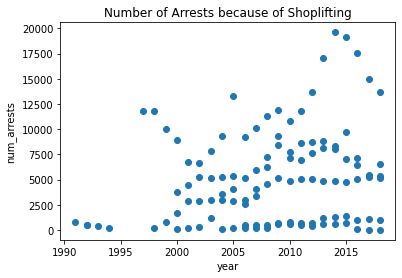

In [245]:
plot_crime(shoplifting_all, 'year', 'num_arrests', "Shoplifting")

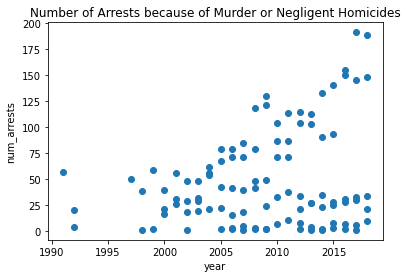

In [246]:
plot_crime(murder_all, 'year', 'num_arrests', "Murder or Negligent Homicides")

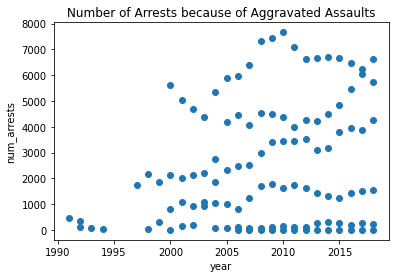

In [249]:
plot_crime(a_assault_all, 'year', 'num_arrests', 'Aggravated Assaults')

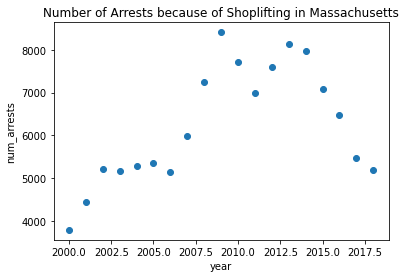

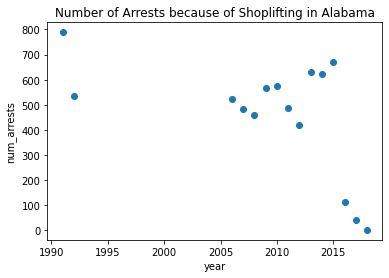

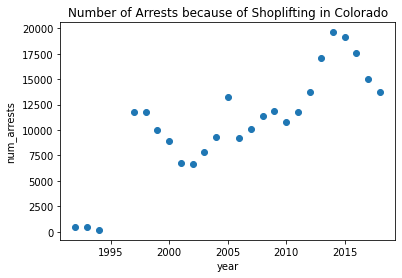

In [258]:
# Here we"ve plotted 3 states shoplifting data individually so you can get a sense
# for the trend 

plot_crime(shoplifting_ma, 'year', 'num_arrests', "Shoplifting in Massachusetts")
plot_crime(shoplifting_al, 'year', 'num_arrests', "Shoplifting in Alabama")
plot_crime(shoplifting_co, 'year', 'num_arrests', "Shoplifting in Colorado")

In [219]:
# consistent random_state acorss all three split_train_tests
rand_state = 1

# need to replace state abbreviations with numbers for regression
shoplifting_all['state']=shoplifting_all.state.astype("category").cat.codes
murder_all['state'] = murder_all.state.astype("category").cat.codes
a_assault_all['state'] = a_assault_all.state.astype("category").cat.codes

# remove target from data for each crime
shoplifting_all_y = shoplifting_all['num_arrests']
shoplifting_all_X = shoplifting_all.drop('num_arrests',1)
murder_all_y = murder_all['num_arrests']
murder_all_X = murder_all.drop('num_arrests',1)
a_assault_all_y = a_assault_all['num_arrests']
a_assault_all_X = a_assault_all.drop('num_arrests',1)

# split_test_train on the data, used 1/3 test per good rule of thumb
shoplifting_all_X_train, shoplifting_all_X_test, \
shoplifting_all_y_train, shoplifting_all_y_test = \
train_test_split(shoplifting_all_X, shoplifting_all_y, \
                 test_size=0.33, random_state=rand_state)

murder_all_X_train, murder_all_X_test, \
murder_all_y_train, murder_all_y_test = \
train_test_split(murder_all_X, murder_all_y, \
                 test_size=0.33, random_state=rand_state)

a_assault_all_X_train, a_assault_all_X_test, \
a_assault_all_y_train, a_assault_all_y_test = \
train_test_split(a_assault_all_X, a_assault_all_y, \
                 test_size=0.33, random_state=rand_state)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

In [284]:
# init the model for each crime
shoplifting_regression = LinearRegression()
murder_regression = LinearRegression()
a_assault_regression = LinearRegression()

# fit the model using the training data
shoplifting_regression.fit(shoplifting_all_X_train, shoplifting_all_y_train)
murder_regression.fit(murder_all_X_train, murder_all_y_train)
a_assault_regression.fit(a_assault_all_X_train, a_assault_all_y_train)

# predict what the values will be
shoplifting_predict = shoplifting_regression.predict(shoplifting_all_X_test)
murder_predict = murder_regression.predict(murder_all_X_test)
a_assault_predict = a_assault_regression.predict(a_assault_all_X_test)

# show how good the models performed
print("Score of Shoplifting Model across all states is: \t\t" + \
      str(shoplifting_regression.score(shoplifting_all_X_test, shoplifting_all_y_test)))
print("Score of Murder Model across all states is: \t\t\t" + \
      str(murder_regression.score(murder_all_X_test, murder_all_y_test)))
print("Score of Aggravated Assaults Model Across all states is: \t" + \
      str(a_assault_regression.score(a_assault_all_X_test, a_assault_all_y_test)))

# i tested the models using varying random_states for the split_test_train
# Shoplifting was consistenting more accurate than the other two, most likely
# on account of being a larger dataset. It hovers around 85 to 92 in terms of
# score. Murder and aggravated assault hover around mid 70s to mid 80s

Score of Shoplifting Model across all states is: 		0.8698647356709069
Score of Murder Model across all states is: 			0.7800985452525789
Score of Aggravated Assaults Model Across all states is: 	0.8015226129666969


In [291]:
# function to train a smaller model for a single state for a crime
# won't be as accurate as the models above but offers a good visual
# into how the model works

def plot_crime_for_state(crime_df, state_name, crime_name):

    crime_df = crime_df.sort_values(by=['year'])

    crime_reg = LinearRegression()
    crime_df['state']=crime_df.state.astype("category").cat.codes
    crime_reg.fit(crime_df.drop('num_arrests',1), crime_df['num_arrests'])

    plt.scatter(crime_df['year'], crime_df['num_arrests'], color='b')
    plt.title("Example of Regression on " + state_name +" for " + crime_name)
    plt.xlabel("Year")
    plt.ylabel("Number of Arrests")
    plt.plot(crime_df['year'],crime_reg.predict(crime_df.drop('num_arrests',1)),color='k')
    plt.show()

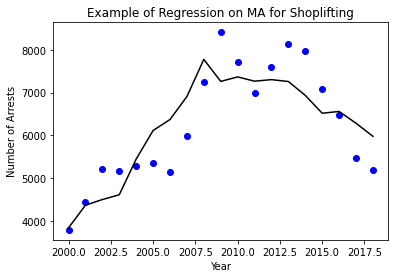

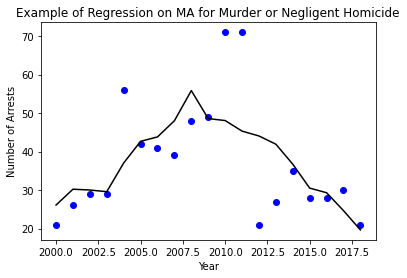

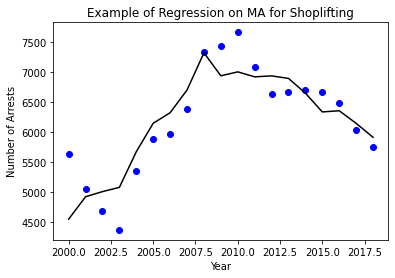

In [293]:
plot_crime_for_state(shoplifting_ma, "MA", "Shoplifting")
plot_crime_for_state(murder_ma, "MA", "Murder or Negligent Homicide")
plot_crime_for_state(a_assault_ma, "MA", "Shoplifting")

#Future Improvements:
I would like to include other datasets next containing information about the demographic of each state. This dataset contains information on the race and ethnicity of each arrestee and victim but without the demographics for each state year to year, it was hard to find a model which performed well.

Additionally, I want to acknowledge that this data is somewhat inherently biased. The NIBRS is a self-reporting crime data base and is not required by the FBI, which results in the some of the inconsistencies in the data which we had to account for above. Additionally this is by no means information on every single crime in the U.S. so any knowledge we learn from this hopefully is representative of the larger dataset of all crime in the U.S. but there is no way to see if we have an accurate sampling.

#Appendix A: Below are other schemas we used to read in data. 
We no longer needed those tables but decided to keep the schemas just in case a need should arise later.

In [16]:
victim_circumstances_schema = StructType([ StructField("victim_id", IntegerType(), True)\

                       ,StructField("circumstances_id", IntegerType(), True)\

                       ,StructField("justifiable_force_id", DoubleType(), True)\

                       ,StructField("state", StringType(), True)\

                       ,StructField("data_year", DoubleType(), True)])

In [17]:
victim_schema = StructType([ StructField("victim_id", IntegerType(), True)\

                       ,StructField("incident_id", IntegerType(), True)\

                       #,StructField("victim_seq_num", IntegerType(), True)\

                       #,StructField("victim_type_id", IntegerType(), True)\

                       #,StructField("assignment_type_id", DoubleType(), True)\

                       #,StructField("activity_type_id", DoubleType(), True)\

                       #,StructField("outside_agency_id", DoubleType(), True)\

                       #,StructField("age_id", DoubleType(), True)\

                       #,StructField("age_num", DoubleType(), True)\

                       #,StructField("sex_code", StringType(), True)\
                       
                       ,StructField("race_id", DoubleType(), True)\
                       
                       ,StructField("ethnicity_id", DoubleType(), True)\
                       
                       #,StructField("resident_status_code", StringType(), True)\
                       
                       #,StructField("agency_data_year", DoubleType(), True)\
                       
                       #,StructField("ff_line_number", DoubleType(), True)\
                       
                       #,StructField("age_range_low_num", DoubleType(), True)\
                       
                       #,StructField("age_range_high_num", DoubleType(), True)\
                       
                       ,StructField("state", StringType(), True)\
                       
                       #,StructField("data_year", DoubleType(), True)\
                       
                       ])

In [18]:
races_schema = StructType([ StructField("race_id", IntegerType(), True)\

                       #,StructField("race_code", StringType(), True)\

                       ,StructField("race_desc", StringType(), True)\

                       #,StructField("start_year", DoubleType(), True)\

                       #,StructField("end_year", DoubleType(), True)\

                       #,StructField("notes", StringType(), True)\

                       #,StructField("state", StringType(), True)

                        ])

In [7]:
circumstances_schema = StructType([ StructField("circumstances_id", IntegerType(), True)\

                       ,StructField("circumstances_type", StringType(), True)\

                       ,StructField("circumstances_code", IntegerType(), True)\

                       ,StructField("circumstances_name", StringType(), True)\

                       ,StructField("state", StringType(), True)\
                       
                       ,StructField("year", IntegerType(), True)])